In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

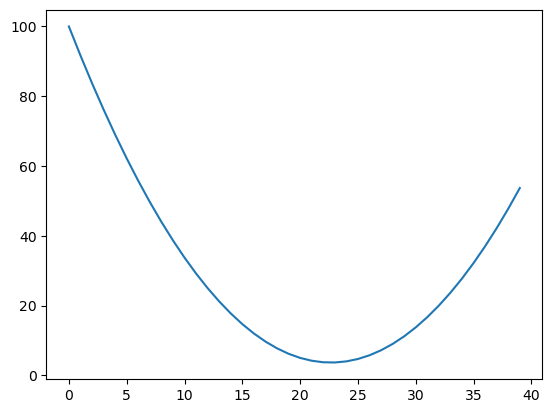

In [5]:
plt.plot(ys) 

In [6]:
h = 0.000001 
x = 2/3 
(f(x+h) - f(x)) / h 

2.999378523327323e-06

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c         
c += h            
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0          
        self._backward = lambda: None                  
        self._prev = set(_children)           
        self._op =_op                        
        self.label = label
        
    def __repr__(self): 
        return f"Value (data = {self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other), '+') 
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad  
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def __pow__(self, other): # creating a power/exponential function
        assert isinstance(other, (int, float)), "only supporting int and float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # check derivative of power chain rule on google.. this is it only
        out._backward = _backward
        return out

    def __rmul__(self, other): #other, self
        return self * other

    def __truediv__(self, other): # self/other
        return self * (other**-1)           # for division a/b = a * (1/b) = a * (b**-1) 
    def __neg__(self):  # -self
        return self * -1
    def __sub__(self, other): #self - other
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)     
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x =self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad   # d(e**x)/dx = e**x
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
a = Value(2.0)
b = Value(4.0)
a-b

Value (data = -2.0)

In [11]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})  

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)


    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label = 'x2')

# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias for the nueron
b = Value(6.8813735870195432, label = 'b')

# performing x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'     
o.backward()

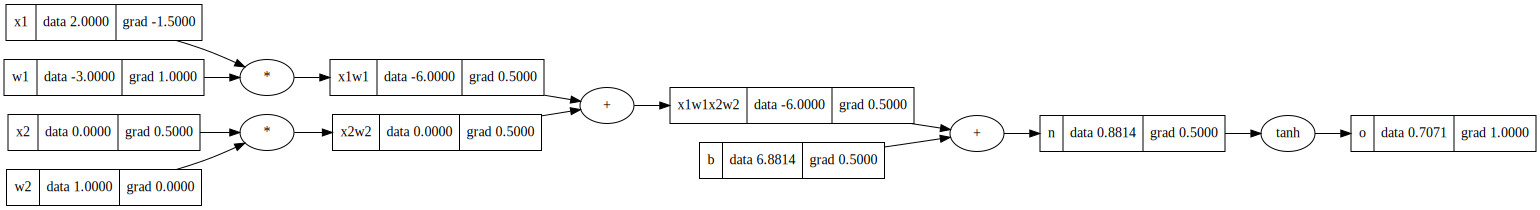

In [13]:
draw_dot(o)

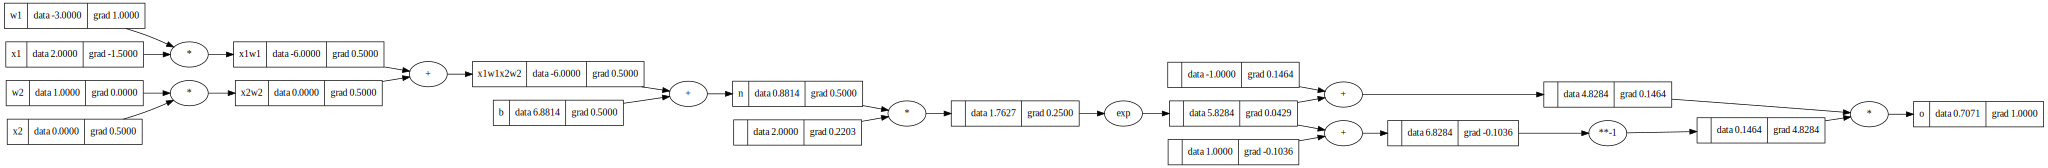

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label = 'x2')

# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias for the nueron
b = Value(6.8813735870195432, label = 'b')

# performing x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 + b; n.label = 'n'

# o = n.tanh();   #instead of using tanh directly let's use the mathematical formula of tanh that we have and we added functions +,-,*,exp,pow..etc
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'     
o.backward()
draw_dot(o)

In [15]:
import torch

# Explanation of below PyTorch code
## In above code we have created a Scalars i.e., single value element but in PyTorch..
## We have Tensors which stores element in the form of vectors in c++ or we can say in matrix format
We use .double() because double is the format in which python considers any floating point integer <br>
We have to add .requires_grad = True as by default in PyTorch the gradient calculation of variable is set to false for optimization purpose <br>
## Out of many element to get back the one single element we want we use .item() or .data.item()  ad they slice the single variable from all other variables present in Tensor
We perform .item() or .data.item() both gives the same results.. they return the single element value out of many other present in the tensors

In [16]:
x1 = torch.Tensor([2.0]).double()                         ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                         ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                        ; w1.requires_grad = True          
w2 = torch.Tensor([1.0]).double()                         ; w2.requires_grad = True 
b = torch.Tensor([6.8813735870195432]).double()           ; b.requires_grad = True
n = x1*w1 + x2*w2 + b                                     
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Creating a nueral network 

# Explaining class Neuron
The __init__ method takes, self, and nin as input parameters, the __nin__ is the number of __input__ nueron or 'x' in wi*xi to be there <br>
self.w generates __random__ values for weight 'w' for each wi*xi and self.b generates random value for bias 'b' <br>
def __call__ this method will be __executed__ when we call the Neuron class and the __structure__ of Neuron class was defined in __init__ function <br>
act is __activaiton__ i.e., activation for __nueron__ a passing threshold you can say and out = output w.r.t tanh() <br>
## Zip function
__zip__ function creates two variables w and x as a pair (w, x) (as we passed these names), from the values present in the tuple <br>
and __iterates__ over the tuple till it is completed <br>
you can __check__ how it __creates__ by printing following line "print(list(zip(self.w,x)))" before the return out statement of __call__ function <br>
These __pairs__ are then multiplied as (wi * xi) as we have mentioned at the start __wi*xi__ for...... this makes them multiply <br>
and then at last we sum them to get __activtion__ __function__ <br>
## sum
in __sum__ we can pass two variables, we __first__ have passed the input whose sum we want and __then__ instead of adding __bias__ __outsinde__ we just __wrote__ it here __inside__ as this value is by __default__ __=__ __0__. So just for __efficiency__ we added __bias__ __inside__, we could have __added__ bias __outside__ also 

In [17]:
import random

In [18]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value (data = 0.9788586015312543)

# The above code was for just single nueron the below code is for a whole multi-layer Nueral Network

# Layer Class Explanation
In the __init__ function we pass __3__ inputs.. self, nin, nout <br>
The __nin__ is the number of __input__ __neurons__ we want in __input layer__ <br>
The __nout__ is the number of __perceptron/neurons__ we want in __"output layer" or "nextlayer" or "hidden layer"__ <br>
The __call__ function __evaluates__ the neuron of input layer for __each neuron__ in __output/perceptron/hidden layer__

# MLP i.e., Multi-Layer-Perceptron Class Explanation
Instead of creating __single nouts layer__ like we did in __earlier method__ we create a list of these __hidden/perceptron__ layer in one __single execution__ as __nouts__ here is a __"list"__ <br>
__nouts__ contain the __sizes of each layer__ we want in a form of a __list__ <br>
In __sz__ we put all the __sizes together__ <br>
In __self.layers__ we __iterate__ over __each sizes__ and __create__ a __object Layer__ for __each__ of the __sizes__ <br>
In __call__ function we call them __sequentially__

In [19]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons =[Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # return outs    # this returns a list in single value, so we can't clearly understand anything from it
        return outs[0] if len(outs) == 1 else outs     # this will give us the output of last single neuron 
                                                       # which is present after all the hidden and input layers the output 
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [20]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value (data = -0.7777738758387135)

In [21]:
# n.parameters()               # value of each parameter
len(n.parameters())            # total number of parameters  

41

In [22]:
# draw_dot(n(x))   # If you want to see how your neural network looks check this for fun

# The below code is an example for the MLP we created above
In __xs__ we have __created__ a __list__ of __inputs__ for our MLP <br>
In __ys__ we have kept what output we want, this is __just__ for __visualization__ we __haven't used ys__ anywhere <br>
You could __write ys__ in __notepad__ or keep in your mind as well we just kept it here for __easy visualization__ purpose <br>
In __ypred__ we __calculate__ __n(x)__ as we calculated above, for __each input__ in __xs__ <br>
The __for loop__ variable __x iterates__ over __each elements__ <br>
__x__ takes __one input__ and then __n(x)__ is __calculaed__ for it then x takes next input calculates for it in n(x) and __so on__..<br>
__ypred__ is a __list__ so it __stores__ all the __outputs__ and then print it

In [23]:
xs = [
      [2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0 -1.0],
     ]

ys = [1.0, -1.0, -1.0, 1.0]  # desired output
# ypred = [n(x) for x in xs]
# ypred

# We check how much loss is there i.e., how much is the outputs we got differ from the original target output
We create ygt (y ground truth or actual or expected) and yout (output/predicted) and use zip to tuple or create pair of yout and ygt <br>
Explanation of zip is given earlier during Single Neuron Creation <br>

In [24]:
# [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

# We sum all the individual losses to get the final loss of model

In [26]:
ypred = [n(x) for x in xs]
loss = Value(0.0)
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2

loss

Value (data = 6.788310443456489)

In [27]:
ypred = [n(x) for x in xs]
loss = Value(0.0)
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt)**2

loss

Value (data = 6.788310443456489)

In [28]:
loss.backward()   # to calculate gradient or backward pass or back propagation

In [29]:
# details are given in below explanation
for p in n.parameters():
    p.data += -0.01 * p.grad

In [30]:
ypred

[Value (data = -0.7777738758387135),
 Value (data = -0.8427273507513604),
 Value (data = -0.8989987711178261),
 Value (data = -0.895493222199566)]

In [31]:
n.parameters()   # these are the parameters which make the neural network predict output 

[Value (data = 0.9514880512849969),
 Value (data = -0.8636028666846277),
 Value (data = -0.32842008465655004),
 Value (data = 0.3978718141169018),
 Value (data = -0.4213321950004544),
 Value (data = 0.04415066717949081),
 Value (data = 0.746948113306603),
 Value (data = 0.6956176220054445),
 Value (data = 0.9619218810251072),
 Value (data = 0.5803884558023011),
 Value (data = 0.810422845315749),
 Value (data = -0.07505861250895775),
 Value (data = -0.20179406399557695),
 Value (data = -0.29411750060506936),
 Value (data = -0.8516847790200833),
 Value (data = 0.582281193159083),
 Value (data = -0.15349046626232038),
 Value (data = 0.20578361348835109),
 Value (data = -0.3223106287607131),
 Value (data = 0.5279684091947937),
 Value (data = -0.0016700927170291875),
 Value (data = 0.11987355593256178),
 Value (data = -0.07924532798131084),
 Value (data = 0.12387064628423564),
 Value (data = 0.026667510022075656),
 Value (data = -0.22886337153297592),
 Value (data = -0.022841365410888628),


# We are using gradient descent 
## So in gradient descent the vector (think of graph and then vector in it) points in a direction where if you increase it the loss increases
## But we need to reduce the loss so we use negative '-' to step i.e., 0.01 in this case
## Hence we use '-' to step i.e., -0.01 (negative) instead of 0.01 (positive) so that the model loss decreases instead of increasing

In [32]:
# n.layers[0].neurons[0].w[0].data   # data used by the nueron or input

In [33]:
# n.layers[0].neurons[0].w[0]       

In [34]:
# n.layers[0].neurons[0].w[0].grad   #calcuates gradient

In [35]:
# draw_dot(loss)

In [38]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = Value(0.0)
    for ygt, yout in zip(ys, ypred):
        loss += (yout - ygt)**2

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.09260412809326292
1 0.08682563156271686
2 0.0816826048047575
3 0.0770783944644653
4 0.07293470737760974
5 0.06918749190222268
6 0.06578387272489182
7 0.06267983913159315
8 0.05983848024523078
9 0.057228622747174746
10 0.0548237684696679
11 0.05260125797824326
12 0.05054160627626278
13 0.04862797089573315
14 0.04684572274496961
15 0.045182097396579926
16 0.04362590984891629
17 0.04216731974777809
18 0.04079763700506167
19 0.03950915997187769


In [39]:
ypred

[Value (data = 0.9511912574185977),
 Value (data = -0.8798687324893718),
 Value (data = -0.9242150099208517),
 Value (data = 0.8698002286311786)]